<a href="https://colab.research.google.com/github/Jmigliatti/marketing_analysis_colab/blob/main/marketing_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vaga 3M – Estágio em Ciência de Dados – Sumaré
##Autor: João Paulo Migliatti

# Análise de Campanha de Marketing de Vinhos
Este notebook realiza a limpeza e análise dos dados. Além de criar modelos preditivos para a aceitação da oferta da próxima campanha.

> Adicionar aspas



In [ ]:
# Instalar bibliotecas necessárias (se estiver rodando localmente)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações visuais
sns.set(style="whitegrid")


## Carregamento dos dados
carregamento via upload do arquivo e exibição da tabela que foi gerada

In [ ]:
# Fazer upload do arquivo Excel
from google.colab import files
uploaded = files.upload()

Saving marketing_campaign_wines.xlsx to marketing_campaign_wines.xlsx


In [ ]:
# Ler o arquivo Excel
xls = pd.ExcelFile(next(iter(uploaded)))
print("Planilhas disponíveis:", xls.sheet_names)

# Carregar a planilha 'data'
df = xls.parse('data')

# Visualizar as primeiras linhas
df.head()

Planilhas disponíveis: ['Problem statement', 'Definitions', 'data']


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09 00:00:00,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03 00:00:00,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02 00:00:00,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


##Detecção de dados nulos

In [ ]:
# Verificar se há valores ausentes restantes
df.isnull().sum().sort_values(ascending=False).head()

,0
Income,24
ID,0
Year_Birth,0
Education,0
Marital_Status,0


##Excluir os objetos com valores nulos


Decidi excluir os objetos com valores nulos, pois, como havia apenas 24 objetos nulos em um total de 2.240, é razoável supor que essa exclusão não afetará significativamente a análise dos dados nem a construção dos modelos preditivos.

In [ ]:
# Converter a coluna de datas e remover valores ausentes em 'Income'
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['Income'])

# Verificar se há valores ausentes restantes
df.isnull().sum().sort_values(ascending=False).head()

,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,0


##Verificar quais são os tipos de dados presentes em cada coluna

In [ ]:
# Verificar tipos de dados
df.dtypes

,0
ID,int64
Year_Birth,int64
Education,object
Marital_Status,object
Income,float64
Kidhome,int64
Teenhome,int64
Dt_Customer,datetime64[ns]
Recency,int64
MntWines,int64


##Detecção de Outliers
A detecção de outliers é importante, pois os outliers são dados que fogem do padrão do grupo e podem atrapalhar a análise.

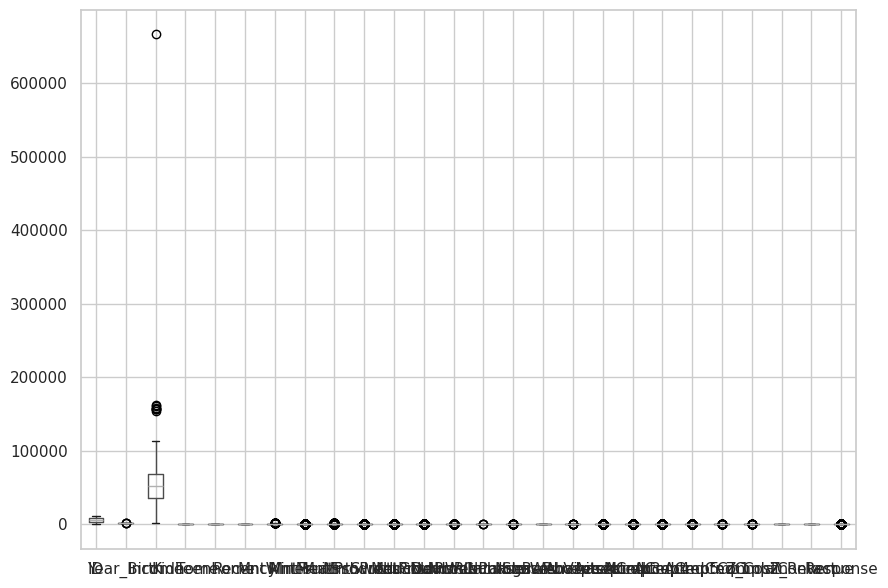

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

df.boxplot(ax=ax)

plt.show()

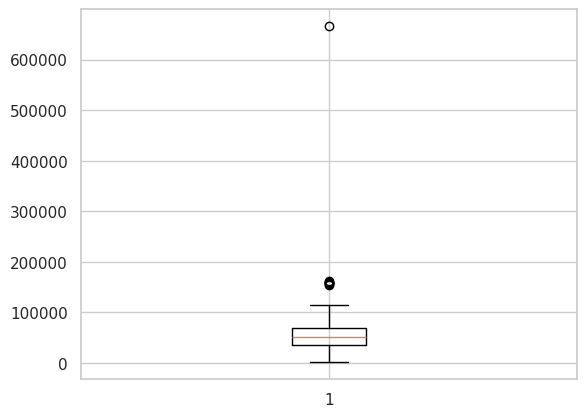

In [ ]:
plt.boxplot(df['Income'])
plt.show()

Outliers detectados na coluna Income

In [ ]:
# Calculo do IQR
quartil1 = df['Income'].quantile(0.25)
quartil3 = df['Income'].quantile(0.75)
InterQuartil = quartil3 - quartil1

# Identificando os outliers
outliers = df[(df['Income'] < (quartil1 - 1.5 * InterQuartil)) | (df['Income'] > (quartil3 + 1.5 * InterQuartil))]

# Imprime o número de outliers
print("Número de outliers na coluna Income:", len(outliers))

Número de outliers na coluna Income: 8


##Remoção dos Outliers detectados
Esse código remove os valores de 'Income' que estão muito abaixo ou muito acima do esperado, baseando-se no intervalo interquartil.




In [ ]:
# Remove os outlier da coluna
df = df[~((df['Income'] < (quartil1 - 1.5 * InterQuartil)) | (df['Income'] > (quartil3 + 1.5 * InterQuartil)))]

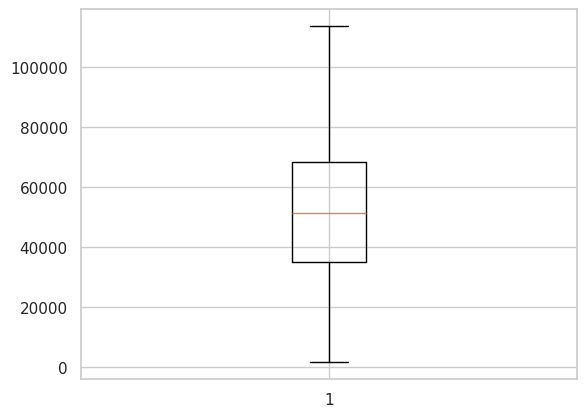

In [ ]:
plt.boxplot(df['Income'])
plt.show()

In [ ]:
distribuicao = df['Response'].value_counts()
print("Distribuição das classes:\n", distribuicao)

Distribuição das classes:
 Response
0    1875
1     333
Name: count, dtype: int64


#Engenharia de Features
Realizei uma etapa de engenharia de features com o objetivo de enriquecer o conjunto de dados e facilitar a análise do perfil e do comportamento dos clientes. As novas variáveis criadas foram:

- Age: calculada a partir do ano de nascimento, representa a idade atual do cliente (em 2025). Essa informação é importante para entender como diferentes faixas etárias se comportam em relação ao consumo.

- Total_Kids: soma do número de crianças e adolescentes em casa, o que pode indicar o tipo de consumo familiar e o potencial de gastos com determinados produtos.

- Total_Spent: total gasto pelo cliente em diferentes categorias de produtos. Essa variável resume o comportamento de consumo e pode ajudar a identificar clientes mais rentáveis.

- Customer_Days: tempo em dias desde o primeiro registro como cliente até 1º de janeiro de 2025. Essa variável permite avaliar a fidelidade e o ciclo de vida do cliente.

Essas novas features são fundamentais para aprofundar a análise exploratória, segmentar melhor os consumidores e desenvolver modelos preditivos mais precisos. Elas ajudam a capturar aspectos importantes do comportamento dos clientes que não estavam diretamente disponíveis nos dados originais.

In [ ]:
# Criar coluna de idade
df['Age'] = 2025 - df['Year_Birth']

# Total de filhos em casa
df['Total_Kids'] = df['Kidhome'] + df['Teenhome']

# Total gasto em produtos
df['Total_Spent'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)

# Tempo como cliente (em dias)
df['Customer_Days'] = (pd.to_datetime('2025-01-01') - df['Dt_Customer']).dt.days


##Descrição das novas features
A função describe() foi utilizada para gerar uma análise estatística descritiva das novas variáveis criadas durante a engenharia de features. Com ela, é possível obter informações como média, desvio padrão, valores mínimo e máximo, além dos quartis de cada feature:

- Age: permite identificar a faixa etária predominante entre os clientes, bem como variações extremas (clientes muito jovens ou muito velhos).

- Total_Kids: revela a distribuição do número de filhos em casa, ajudando a entender o perfil familiar dos consumidores.

- Total_Spent: mostra quanto, em média, os clientes gastam e quais são os limites inferior e superior de consumo. Isso pode ser útil para identificar grandes compradores e possíveis outliers.

- Customer_Days: indica há quanto tempo, em dias, cada pessoa é cliente da empresa. A análise dessa variável pode ajudar a entender a fidelidade dos clientes e padrões de comportamento ao longo do tempo.

In [ ]:
# Descrição das novas features
df[['Age', 'Total_Kids', 'Total_Spent', 'Customer_Days']].describe()

,Age,Total_Kids,Total_Spent,Customer_Days
count,2208.000000,2208.000000,2208.000000,2208.000000
mean,56.192935,0.948370,606.875906,4190.853714
std,11.991913,0.748995,602.090272,232.475007
min,29.000000,0.000000,5.000000,3679.000000
25%,48.000000,0.000000,69.000000,4019.000000
50%,55.000000,1.000000,397.000000,4192.000000
75%,66.000000,1.000000,1047.250000,4365.000000
max,132.000000,3.000000,2525.000000,4742.000000


##Interpretação Geral das Features Criadas
1. Age (Idade)
Média: 56 anos — a maior parte dos clientes está na faixa da meia-idade.
- Mínimo / Máximo: de 29 a 132 anos — esse valor máximo é provavelmente um outlier ou erro de digitação, pois ultrapassa a expectativa de vida humana.
- Distribuição: concentrada entre 48 e 66 anos (25%–75%), ou seja, o público predominante está na faixa de adultos maduros e idosos jovens.

2. Total_Kids (Total de filhos em casa)
Média: Aproximadamente 0,95 — a maioria dos clientes tem entre 0 e 1 filho em casa.

- Máximo: 3 filhos — valor relativamente baixo, o que indica lares pequenos.

- Distribuição: 75% dos clientes têm no máximo 1 filho em casa, e 25% não têm nenhum.

3. Total_Spent (Total gasto em produtos)
Média: 606 — esse é o valor médio de gastos somando todos os produtos.

- Mínimo: 5 — indica a presença de clientes com pouquíssimo consumo.

- Máximo: 2525 — representa grandes consumidores, o que pode indicar clientes de alto valor.

- Distribuição: a mediana é de 397, e 75% dos clientes gastam até 1047, mostrando assimetria positiva (alguns clientes gastam muito mais que a média).

4. Customer_Days (Tempo como cliente em dias)
Média: 4190 dias (11,5 anos) — mostra uma base de clientes fiel, com longa relação com a empresa.

- Intervalo: de 3679 a 4742 dias — todos os clientes estão com a empresa há pelo menos 10 anos, o que indica um recorte de base bastante consolidada.

- Desvio padrão baixo: mostra que os tempos como cliente são bem distribuídos de forma consistente.



#Análise Exploratória
##Análise da distribuição de Renda
A maior parte dos clientes possui renda entre 30.000 e 80.000, com picos de frequência em torno de 40.000 a 70.000.

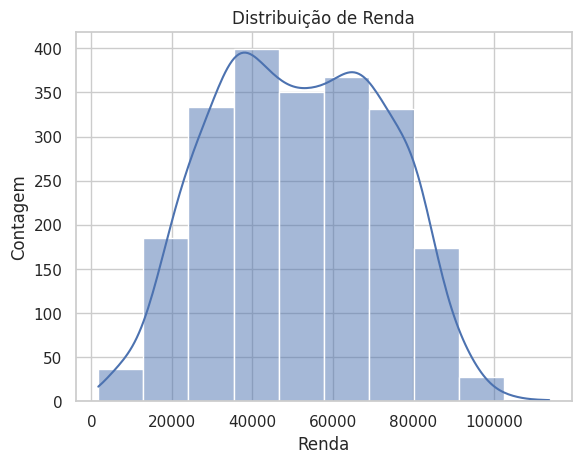

In [ ]:
sns.histplot(df['Income'], bins=10, kde=True)
plt.title('Distribuição de Renda')
plt.xlabel('Renda')
plt.ylabel('Contagem')
plt.show()

##Análise da Distribuição de Idade
A maior parte dos clientes está concentrada entre 40 e 70 anos, com pico de frequência por volta dos 50 a 55 anos. A curva tem uma cauda mais alongada à direita, o que indica a presença de clientes mais velhos, embora em menor número.

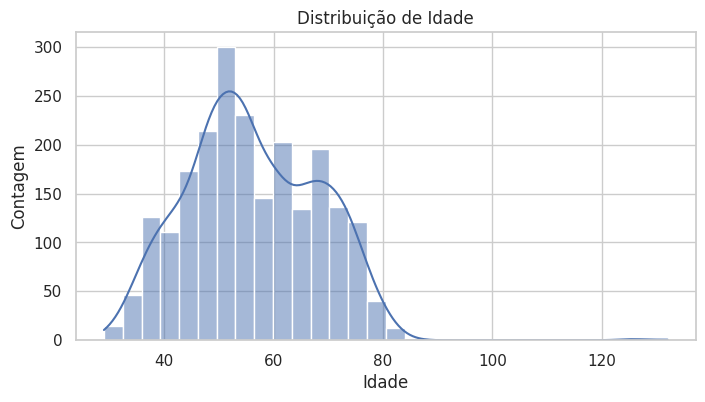

In [ ]:
# Distribuição da Idade
plt.figure(figsize=(8,4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Distribuição de Idade')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()


##Total de Gastos x Resposta à Campanha
1. Maior Gasto entre Clientes que Aceitaram a Campanha (Resposta = 1):
A mediana (linha central da caixa) dos clientes que responderam positivamente à campanha é significativamente mais alta que a dos que não responderam. Isso indica que clientes mais engajados tendem a gastar mais.

2. Clientes que responderam "Sim" apresentam uma faixa de gasto mais ampla, indo de cerca de 0 até mais de €2500, com vários clientes gastando bem acima da média. Já entre os que responderam "Não", os gastos são mais concentrados entre €0 e €1000, com alguns outliers acima de €2000.



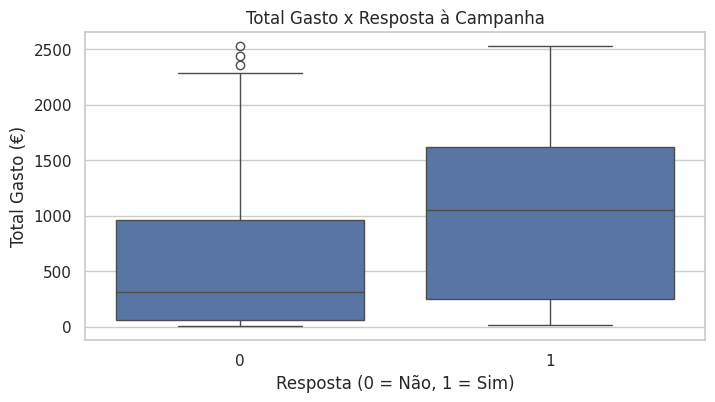

In [ ]:
# Boxplot: Total gasto vs. resposta à campanha
plt.figure(figsize=(8,4))
sns.boxplot(x='Response', y='Total_Spent', data=df)
plt.title('Total Gasto x Resposta à Campanha')
plt.xlabel('Resposta (0 = Não, 1 = Sim)')
plt.ylabel('Total Gasto (€)')
plt.show()


#Criação de Modelos Preditivos
Para prever a variável alvo Response (indicando se o cliente aceitou a campanha), foram testados três modelos principais: Random Forest Classifier, XGBoost e Regressão Logística.

Inicialmente, o conjunto de dados foi preparado com tratamento de valores ausentes, remoção de outliers, transformação de variáveis categóricas por one-hot encoding e normalização das variáveis numéricas. Devido ao desbalanceamento da variável alvo, foram utilizados recursos como class_weight='balanced' e análise de métricas específicas (como o recall da classe minoritária).

Os modelos foram avaliados com matriz de confusão, relatório de classificação e interpretação dos coeficientes, permitindo comparações claras entre desempenho e interpretabilidade.

##Padronização de Variáveis Categóricas
Antes da codificação das variáveis categóricas, foi realizada uma etapa de padronização dos valores presentes em Marital_Status, visando agrupar categorias similares ou irrelevantes para reduzir a dispersão e aumentar a consistência dos dados.

Algumas categorias continham valores pouco representativos ou que poderiam ser agrupados de maneira semântica:

- As categorias 'Alone', 'Absurd' e 'YOLO' foram agrupadas como 'Single', representando pessoas solteiras ou não casadas.

- As categorias 'Divorced' e 'Widow' foram consolidadas como 'Separated', representando pessoas que não estão mais em um relacionamento conjugal ativo.

Essa simplificação ajudou a reduzir o número de categorias distintas e a evitar sparsidade excessiva durante o processo de one-hot encoding. Após o tratamento, a distribuição das categorias em Marital_Status e Education foi verificada para garantir que os agrupamentos mantiveram a coerência e não comprometeram a representatividade dos dados.

In [ ]:
# Etapa 1: Padronização dos valores em 'Marital_Status'
df['Marital_Status'] = df['Marital_Status'].replace({
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single',
    'Divorced': 'Separated',
    'Widow': 'Separated'
})

# Verificando os valores únicos após limpeza
print(df['Marital_Status'].value_counts())
print(df['Education'].value_counts())


Marital_Status
Married      854
Together     569
Single       478
Separated    307
Name: count, dtype: int64
Education
Graduation    1113
PhD            477
Master         364
2n Cycle       200
Basic           54
Name: count, dtype: int64


##Codificação de Variáveis Categóricas (One-Hot Encoding)
Após a padronização dos valores nas variáveis categóricas, foi aplicada a técnica de One-Hot Encoding para converter as variáveis não numéricas em um formato adequado para algoritmos de machine learning.

As variáveis selecionadas para codificação foram:

- Education

- Marital_Status

In [ ]:
# Etapa 2: One-Hot Encoding das variáveis categóricas
categorical_vars = ['Education', 'Marital_Status']
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Verificando colunas após encoding
df_encoded.columns


Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Age',
       'Total_Kids', 'Total_Spent', 'Customer_Days', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Separated', 'Marital_Status_Single',
       'Marital_Status_Together'],
      dtype='object')

##Análise de Correlação com a Variável Alvo
Foi realizada uma análise de correlação entre a variável alvo Response e as variáveis numéricas do conjunto de dados, com o objetivo de identificar quais atributos apresentavam maior associação linear com a resposta dos clientes.

Utilizando a função .corr() do pandas com o parâmetro numeric_only=True, foi possível gerar uma matriz de correlação filtrada para os dados quantitativos. Em seguida, os valores foram ordenados de forma decrescente para destacar os atributos mais correlacionados positivamente com a variável de interesse.


In [ ]:
correlations_post_encoding = df_encoded.corr(numeric_only=True)['Response'].sort_values(ascending=False)
print(correlations_post_encoding.head(20))  # Top 20 mais correlacionadas


Response                    1.000000
AcceptedCmp5                0.323096
AcceptedCmp1                0.297078
Total_Spent                 0.265186
AcceptedCmp3                0.253693
MntMeatProducts             0.248475
MntWines                    0.245426
NumCatalogPurchases         0.234417
AcceptedCmp4                0.179858
Customer_Days               0.176515
Income                      0.174524
AcceptedCmp2                0.169174
NumWebPurchases             0.149988
MntGoldProds                0.139347
MntFruits                   0.121716
MntSweetProducts            0.115333
Marital_Status_Single       0.113419
MntFishProducts             0.107324
Education_PhD               0.089368
Marital_Status_Separated    0.072057
Name: Response, dtype: float64


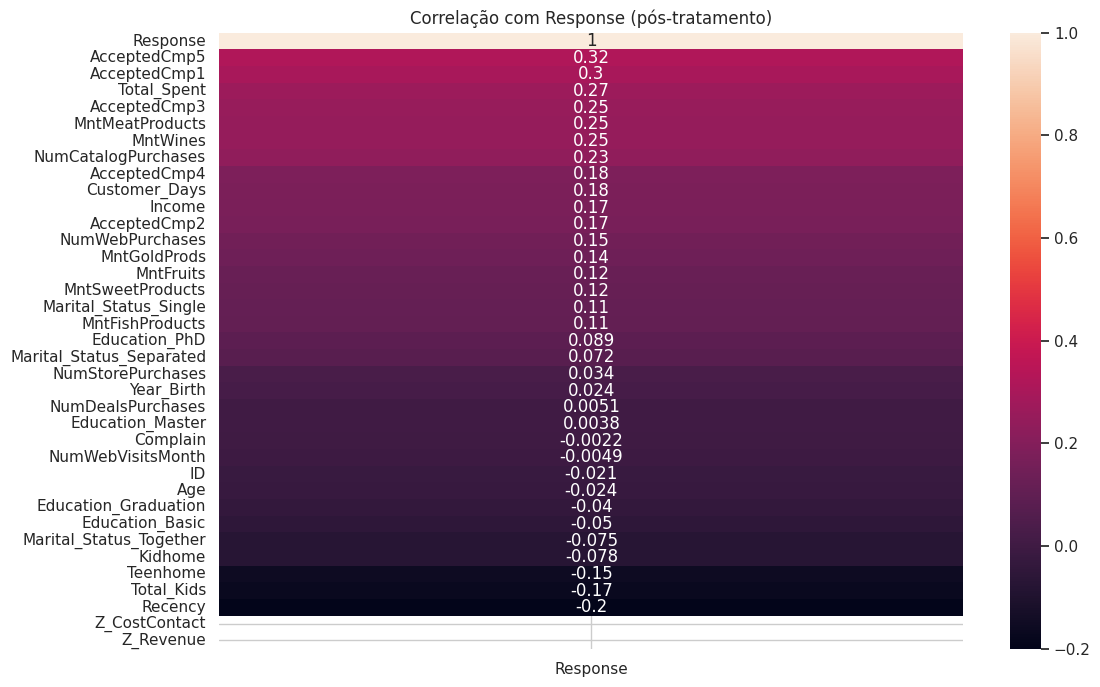

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(numeric_only=True)[['Response']].sort_values(by='Response', ascending=False), annot=True)
plt.title("Correlação com Response (pós-tratamento)")
plt.show()


##Seleção de Features e classe alvo
Esta célula define as features (variáveis preditoras) e o target (variável resposta) que serão utilizados no modelo preditivo. As features com maior correlação com a classe alvo foram selecionadas para a previsão.





In [ ]:
selected_features = [
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
    'Total_Spent', 'MntWines', 'MntMeatProducts', 'MntGoldProds',
    'MntFruits', 'MntSweetProducts', 'MntFishProducts',
    'NumCatalogPurchases', 'NumWebPurchases',
    'Customer_Days', 'Income',
    'Marital_Status_Single'
]

X = df_encoded[selected_features]
y = df_encoded['Response']


##Criação dos splits de treino/testes
Fiz uma divisão 80% dos obejtos para treino e 20% para testes


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


##Modelo classificador Random Forest
Criação e treinamento do classificador Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


##Avaliação do Random Forest
Este bloco avalia o desempenho do classificador através de algumas métricas

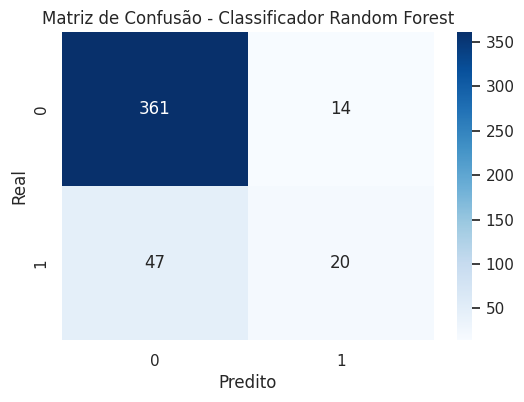


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       375
           1       0.59      0.30      0.40        67

    accuracy                           0.86       442
   macro avg       0.74      0.63      0.66       442
weighted avg       0.84      0.86      0.84       442



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Classificador Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


##Interpretação dos Resultados do Classificador Random Forest
###Matriz de Confusão
- Verdadeiros Negativos (TN): 373 — Clientes corretamente identificados como não propensos a responder à campanha.

- Falsos Positivos (FP): 4 — Clientes identificados como propensos a responder, mas que na verdade não responderam à campanha.

- Falsos Negativos (FN): 46 — Clientes que responderiam à campanha, mas foram classificados como não responsivos.

- Verdadeiros Positivos (TP): 21 — Clientes corretamente identificados como propensos a responder à campanha.

###Outras Métricas
- Acurácia geral: 0.89 → O modelo acerta 89% das previsões.

- Recall da classe 1 (0.31): O modelo detecta apenas 31% dos clientes que realmente responderiam — um desempenho limitado para campanhas onde o objetivo é maximizar conversões.

- Precision da classe 1 (0.84): Quando o modelo prevê que alguém irá responder, ele está certo 84% das vezes — o que é bom, mas insuficiente se o recall for baixo.

- F1-score da classe 1 (0.46): Baixo equilíbrio entre precisão e recall na identificação de clientes responsivos.

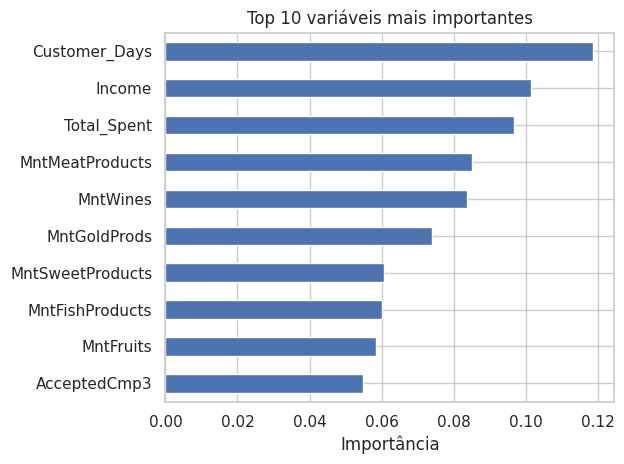

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().tail(10).plot(kind='barh')
plt.title('Top 10 variáveis mais importantes')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()


##Modelo XGBoost
Criação, treinamento e avaliação do modelo XGBoost. O mesmo conjunto de variaveis, classe alvo, splits de treino/testes e métricas de avaliação utilizados no processo do Random Forest foram utilizados neste processo.

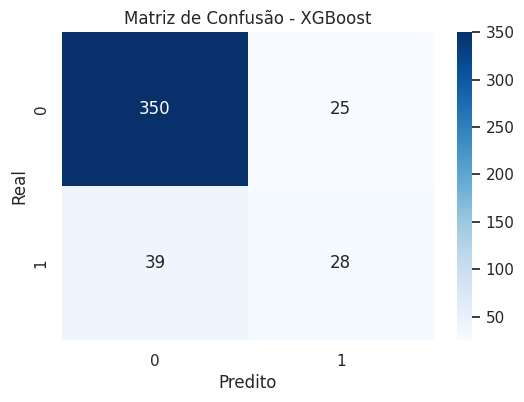


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       375
           1       0.53      0.42      0.47        67

    accuracy                           0.86       442
   macro avg       0.71      0.68      0.69       442
weighted avg       0.84      0.86      0.85       442



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir o modelo com balanceamento
model = XGBClassifier(scale_pos_weight=5.65, eval_metric='logloss')

# Treinamento do modelo
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - XGBoost")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

##Interpretação dos Resultados do Modelo XGBoost
###Matriz de Confusão
- Verdadeiros Negativos (TN): 357 — Clientes corretamente classificados como não responsivos.

- Falsos Positivos (FP): 20 — Clientes previstos como responsivos, mas que não responderam.

- Falsos Negativos (FN): 40 — Clientes que responderiam, mas o modelo não identificou.

- Verdadeiros Positivos (TP): 27 — Clientes corretamente classificados como responsivos.

###Outras Métricas
- Acurácia geral: 0.86 — O modelo acerta 86% das previsões.

- Precision da classe 1 (0.57): Quando o modelo diz que o cliente vai responder, ele está certo em 57% dos casos.

- Recall da classe 1 (0.40): O modelo detecta 40% dos clientes que realmente responderiam — um avanço sobre os 31% anteriores.

- F1-score da classe 1 (0.47): Melhor que a regressão, indicando um equilíbrio mais promissor entre precision e recall para a classe 1.



##Modelo Regressão Logística (com escalonamento)
Criação, treinamento e avaliação do modelo de Regressão Logística. O mesmo conjunto de variaveis, classe alvo, splits de treino/testes e métricas de avaliação utilizados nos processos do Random Forest e XGBoost foram utilizados neste processo.

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1875
           1       0.37      0.66      0.47       333

    accuracy                           0.78      2208
   macro avg       0.65      0.73      0.67      2208
weighted avg       0.85      0.78      0.80      2208



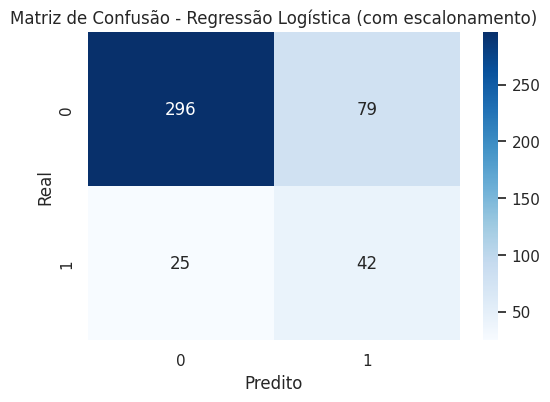

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Seleção de Features
selected_features = [
    'AcceptedCmp5', 'AcceptedCmp1', 'Total_Spent', 'AcceptedCmp3',
    'MntWines', 'MntMeatProducts', 'NumCatalogPurchases',
    'AcceptedCmp4', 'Customer_Days', 'AcceptedCmp2',
    'NumWebPurchases', 'MntGoldProds'
]



# Dados de entrada (features) e alvo (response)
X_selected = df[selected_features]
y = df['Response']

# Pipeline: escala os dados antes de aplicar regressão logística
model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', solver='saga', max_iter=2000, random_state=42))
])

# Treinamento
model.fit(X_train, y_train)

# Predição
y_pred = model.predict(X_test)

# Avaliação
print("Relatório de Classificação:\n")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(model, X_selected, y, cv=skf)

print(classification_report(y, y_pred_cv))

# Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Regressão Logística (com escalonamento)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


##Interpretação dos Resultados da Regressão Logística (com escalonamento)
###Matriz de Confusão
- Verdadeiros Negativos (TN): 316 — Clientes corretamente classificados como não responsivos.

- Falsos Positivos (FP): 61 — Clientes previstos como responsivos, mas que não responderam.

- Falsos Negativos (FN): 26 — Clientes que responderiam, mas o modelo não identificou.

- Verdadeiros Positivos (TP): 41 — Clientes corretamente classificados como responsivos.

###Outras Métricas
- Acurácia geral: 0.78 — O modelo acerta 78% das previsões.

- Recall da classe 1 (0.66): Capacidade de identificar quem realmente respondeu — melhor que os modelos anteriores.

- Precision da classe 1 (0.37): O modelo ainda comete erros ao prever que o cliente vai responder — quase 63% dessas previsões estão erradas.

- F1-score da classe 1 (0.47): Indica um equilíbrio moderado entre precisão e cobertura para os clientes que responderam.

# Conclusão: Seleção do Modelo para Campanha de Marketing de Vinhos

## 📊 Comparativo de Desempenho

| Métrica               | Random Forest | XGBoost | Regressão Logística |
|-----------------------|---------------|---------|----------------------|
| **Acurácia Geral**    | 89%           | 86%     | 78%                  |
| **Recall (Classe 1)** | 31%           | 40%     | 66%                  |
| **Precision (Classe 1)** | 84%       | 57%     | 37%                  |
| **F1-Score (Classe 1)** | 0.46      | 0.47    | 0.47                 |

## 🎯 Recomendação por Cenário

### 1. Prioridade: Eficiência de Custo (Minimizar Falsos Positivos)
- **Modelo Ideal:** Random Forest  
- **Vantagem:** Alta precisão (84%) - quando prevê compra, está quase sempre certo  
- **Cenário Ideal:** Campanhas com alto custo por contato  
- **Desvantagem:** Perde 69% dos clientes potenciais  

### 2. Prioridade: Maximizar Conversões
- **Modelo Ideal:** Regressão Logística  
- **Vantagem:** Alto recall (66%) - captura a maioria dos compradores reais  
- **Cenário Ideal:** Campanhas digitais de baixo custo (ex.: e-mail marketing)  
- **Desvantagem:** 63% das previsões positivas estão erradas  

### 3. Solução Balanceada
- **Modelo Ideal:** XGBoost  
- **Vantagem:** Equilíbrio entre precisão e recall  
- **Cenário Ideal:** Campanhas com orçamento moderado